# Lab 5 Machine Learning and Data Classification

## Table of Contents
1. **[Data: Signal and Background](#Data)**  
   1.1. [What is Data?](#what_is_data)  
   1.2. [Visually Comparing Signal and Background](#compar)  
2. **[Classifier Training](#class_train)**  
   2.1 [Scikit-learn](#scikit)  
   2.2 [Decision Trees and Boosting](#dtrees_and_boosting)  
3. **[Classifier Testing](#class_test)**  
   3.1 [Overtraining Check with Cross Validation](#overtrain_check)  
   3.2 [Roc Curve and Score](#ROC)  


## 1. TTrees <a name="Data" />  
### 1.1 What is Data? <a name="what_is_data" />  
When performing analysis, we are interested in analyzing what we consider to be signal. However, background noise is unavoidable and one of the objectives of an analysis is to reduce the noise as much as possible. We are mostly interested in what the signal is telling us about physics. To eliminate noise, we compare what signal and background look like and use that to classify our data - which is some unknown combination of signal and background. This can be done by simple visual comparison of distributions, or through the use of a neural network which can compare signal and background on a multi-variate level. A classifier has the added benefit of looking at many variables of an single event and comparing that across millions events. Before it can classify the data though, it must be trained to know what signal and background both look like. 

### 1.2 Visually Comparing Signal and Background <a name="compar" />  
For this exercise we will be working with three ROOT files: a background only file, a signal and background file, and a signal only file. Let's visually compare the background and signal before employing the use of the classifier. For this example, we will be working with a generated dataset of particle events with mass, eta, and phi information.

In [2]:
import ROOT
from ROOT import TFile, TTree, TObject, TCanvas
import numpy as np

Welcome to JupyROOT 6.17/01


In [ ]:
#Grab the three decay trees
bkg_file = TFile.Open("../../Datasets/Gen/Lab5_root/example/bkg.root")
bkg_tree = bkg_file.Get("DecayTree")

bkg_sig_file = TFile.Open("../../Datasets/Gen/Lab5_root/example/bkg_and_sig.root")
bkg_sig_tree = bkg_sig_file.Get("DecayTree")

sig_file = TFile.Open("../../Datasets/Gen/Lab5_root/example/sig.root")
sig_tree = sig_file.Get("DecayTree")

#Create TCanvas and plot the mass, phi, and eta from each TTree
canvas = TCanvas("canvas", "Comparing Sig and Bkg", 900, 900)
canvas.Divide(3,3)

#Draw each distribution
#background
canvas.cd(1)
bkg_tree.Draw("mass")
canvas.cd(2)
bkg_tree.Draw("eta")
canvas.cd(3)
bkg_tree.Draw("phi")

#signal
canvas.cd(4)
sig_tree.Draw("mass")
canvas.cd(5)
sig_tree.Draw("eta")
canvas.cd(6)
sig_tree.Draw("phi")

#background and signal
canvas.cd(7)
bkg_sig_tree.Draw("mass")
canvas.cd(8)
bkg_sig_tree.Draw("eta")
canvas.cd(9)
bkg_sig_tree.Draw("phi")

canvas.Draw()

Visually, we can already see the mass distributions between signal and background are different - a gaussian and an exponential respectively. Additionally, there seems to be a coorelation between mass and eta that differs between signal and background. There isn't any clear coorelation between signal and background on the phi distribution. Since these distributions overlap, we cannot simply cut at a certain mass or eta. Although this would eliminate background, it would also eliminate signal. We must find a cut that reduces the most background but also preserves our signal. This is where the classifier becomes useful. Though we can see the coorelation between mass and eta, a classifier can consider both these distributions simultaneously when evaluating whether an event is signal or background. I.e. a low mass event with low eta is probably background, while an event with a mass of 172 MeV and eta of 2 may be difficult to distinguish from signal or background. The classifier will give us its determination as a -1 or 1, or in some cases 0 or 1. This can be on a continuum or boolean based. This depends entirely on the classifier and decision function called from it.

## 2. Classifier Training <a name="class_train" /> 

### 2.1 Scikit-learn <a name="scikit" /> 

In python, we will be using the scikit-learn package for it's machine learning classes. We will discuss the basic function of these classes, but will not go into depth of how they function. First, scikit-learn must be installed. Additionally, we will be using root_pandas to convert the ROOT files to panda's dataframes which can be interpreted by scikit-learn. 

#### Note: These commands are not very stable in jupyter. Run one command, and wait for it to finish before executing the next one. This may take a few tries since the kernal frequently crashes. If it does crash, remember to import ROOT again from the beginning. Installing to your python2 alleviates the need for installing in jupyter.

In [ ]:
!pip install sklearn -q

In [ ]:
!pip install root_pandas -q

From scikit-learn, we will be constructing an Adaboosted classifier from an ensemble of decision trees. The basic idea is that we construct an estimator from a large group of weak classifiers. The classifier tunes these trees during training. 

### 2.2 Decision Trees and Boosting <a name="dtrees_and_boosting" /> 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

base_classifier = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 5)
ada = AdaBoostClassifier(
    base_estimator = base_classifier,
    learning_rate = 0.1,
    n_estimators = 100,
    algorithm = "SAMME")

The parameters which we have control over are called the hyperparameters of the classifier. Often, these will have to be tweaked in order to get the best results. In order to train the classifier, we must tell it what is signal and what is background. This is done by labelling the data.

In [ ]:
import pandas as pd
from root_pandas import read_root, to_root
variables = ["mass", "eta", "phi"]

#Import sig and bkg root files as panda's dataframes
sig_frame = read_root("../../Datasets/Gen/Lab5_root/example/sig.root", key = "DecayTree", columns = variables)
bkg_frame = read_root("../../Datasets/Gen/Lab5_root/example/bkg.root", key = "DecayTree", columns = variables)
#There is a bug in read_root which sometimes shuffles the order of the columns from what you give it
#This only matters when reading out feature_importances

#Label signal as 1 and background as 0
sig_frame["label"] = np.ones(len(sig_frame))
bkg_frame["label"] = np.zeros(len(bkg_frame))

train_frame = pd.concat([bkg_frame, sig_frame], axis = 0)
target_frame = train_frame["label"]
train_frame = train_frame.drop("label", axis = 1)

ada.fit(train_frame, target_frame)

#Let's check the feature importance of each variable
#phi should have a fairly low importance
for i in range(len(variables)):
    print(list(train_frame)[i] + ": " + str(ada.feature_importances_[i]))
    

Strangely, the Boosted Decision Tree (BDT) classifier has determined the mass to be slightly, and despite phi being the same between signal and background, it has determined it to be very slightly important. The BDT doesn't think about the distributions from a human perspective. It only sees sets of numbers, and determines what is signal or background based on the value and relationship between the numbers. We can at least see that ETA is the most important feature - which is to be expected. 

In [ ]:
bkg_sig_frame = read_root("../../Datasets/Gen/Lab5_root/example/bkg_and_sig.root", key = "DecayTree", columns = variables)

#Compute the decision function for every event and get classification
bkg_sig_frame["classification"] = ada.decision_function(bkg_sig_frame)

With the data classified, lets write it to a root file and see what the classified data looks like.

In [ ]:
#Write classified data
to_root(bkg_sig_frame, "../../Datasets/Gen/Lab5_root/example/bkg_and_sig_classified.root", key = "DecayTree")

#open root file and grab ttree
bkg_sig_classified_file = TFile.Open("../../Datasets/Gen/Lab5_root/example/bkg_and_sig_classified.root")
bkg_sig_classified_tree = bkg_sig_classified_file.Get("DecayTree")

canvas_2 = TCanvas("canvas_2", "Classified Data", 1400, 900)
canvas_2.Divide(3,3)
canvas_2.cd(1)
bkg_sig_classified_tree.Draw("classification")
canvas_2.cd(2)
bkg_sig_classified_tree.Draw("mass", "classification < 0")
canvas_2.cd(3)
bkg_sig_classified_tree.Draw("mass", "classification > 0")
canvas_2.cd(5)
bkg_sig_classified_tree.Draw("eta", "classification < 0")
canvas_2.cd(6)
bkg_sig_classified_tree.Draw("eta", "classification > 0")
canvas_2.cd(8)
bkg_sig_classified_tree.Draw("phi", "classification < 0")
canvas_2.cd(9)
bkg_sig_classified_tree.Draw("phi", "classification > 0")
canvas_2.Draw()

Visually, it seems that our classifier did a good job of deciphering between signal and background based on the mass spectrum alone. This signal and background was generated from 70,000 backrgound events and 10,000 signal events. The number of signal and background entries seem to agree with what we generated from. However, we can see some background events were classified as signal, and this can happen vice versa as well. The classifier is not fool-proof and finding the best cut on the classification distribution is an important part of an analysis. It is more important to keep signal than to cut it out for the sake of background reduction. Furthermore, events with classification near 0 aren't clearly signal or background. This may explain why our ETA seems to still have noise at lower values. Some background events have most likely been classified as signal. Nevertheless, this is a useful tool in background reduction.

## 3 Classifier Testing <a name="class_test" /> 

### 3.1 Overtraining Check with Cross Validation <a name="overtrain_check" /> 
The power of machine learning classifier is their generality. Therefore, we want to avoid overtraining. This occurs when the classifier is only able to accurate classify the data it is trained on. We need the classifier to work for the most general situation. An example of overtraining (sometimes called overfitting) is shown below.




In [ ]:
from ROOT import TGraph, gRandom
#generate linear datapoints
m = 2 #slope of the line
b = 0 #y-intercept of the line
ngr = 7 #number of datapoints
gr = TGraph(ngr)

for i in range(ngr):
    x = gRandom.Uniform(-2,2) #randomly pick a value between -2 and 2
    y = b + m*x
    gr.SetPoint(i,x,y) #add the point to the TGraph
    
#Create Linear Fit Function
fitting_function_line = ROOT.TF1("linear", "[0]*x + [1]", -2, 2)
fitting_function_line.SetParameter(0, 2)
fitting_function_line.SetParameter(1, 0)

#Create polynomial of order 9
fitting_function_pol = ROOT.TF1("pol", "pol 9", -2, 2)
fitting_function_pol.FixParameter(1, 0) #so that fit doesn't settle on a line

#Fit fitting function with TGraph
fitting_function_line.SetLineWidth(2)
fitting_function_pol.SetLineWidth(2)
fitting_function_pol.SetLineColor(ROOT.kBlue)
gr.Fit(fitting_function_line, "RSQ")  #Remove Q if you want to see parameter fit results
gr.Fit(fitting_function_pol, "BRS+Q") 

canvas_3 = TCanvas("canvas 3", "Overfitting example", 800, 400)
gr.SetMarkerStyle(3)
gr.SetMarkerSize(2)
gr.SetTitle("Overfitting Example")
gr.Draw()
canvas_3.Draw()

You can run this multiple times and see various examples of this. The line is the true predictor of the relationship between x and y. Even though the polynomial intersects the points, it cannot often correctly predict the true relationship between and x and y (If the polynomial is wildy off from the points, run the script again). This is essentially what is happening in the N-dimensional phase space of our classifier when overtraining occurs.

To check for this, we can 'fold' the training sample. This mean we train the classifier on say 2/3 of the training sample and evaluate the decision function on the remaining 1/3. Ideally, it will still be able accurately to classify the other 1/3 if we have enough statistics. Additionally, we know the true value of the 1/3 so we can decide how accurate it is. This is known as cross validation. Therefore, we will quantify the accuracy of our classifier by calculating the Receiver Operating Characteristic (ROC) score for every fold.

### 3.2 ROC Curve and Score <a name = "ROC" /> 
The ROC curve is a measure of how well the classifier can distinguish between the two groups - signal and background. It is a plot of the true positive rate as a function of the false positive rate for different cut-off points. The ROC score is the area under the curve. Simply put, a ROC score of 0.5 means the classifier is guessing at random the class of an event, and a ROC score of 1 means it is perfect at determining the class of an event. The closer the score is to 1, the better our classifier is. Let's use this method to determine how accurate our classifier is.

Since sklearn works with panda's dataframes and numpy arrays, we will use `matplotlib` to make our plots instead of `ROOT`.

In [ ]:
!pip install matplotlib -q #if missing

In [ ]:
import time
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

kf_train = KFold(n_splits = 3, shuffle = True) #Create folds in data
classifiers = [] #empty list to hold trained classifiers
bdt_classified = target_frame.copy() #initialize classification column

#Initialize matplot plot
plt.figure()

print(time.ctime())
j = 0
for train, test in kf_train.split(train_frame):
    j = j + 1 #keep track of which fold we are in
    x_train, x_test = train_frame.iloc[train], train_frame.iloc[test]
    y_train, y_test = target_frame.iloc[train], target_frame.iloc[test]
    
    #We will be training separate BDT on different parts of the sample
    #these classifiers will be added to the list 'classifiers'
    base_classifier = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 5)
    ada = AdaBoostClassifier(
        base_estimator = base_classifier,
        learning_rate = 0.1,
        n_estimators = 50, #too many estimators leads to memory issues in jupyter, reduced from earlier example
        algorithm = "SAMME")
    
    #Train on 2/3 of the data
    ada.fit(x_train, y_train.ravel())
    #Print Feature Importances
    print("Feature Importances")
    for i in range(len(variables)):
        print(list(train_frame)[i] + ": " + str(ada.feature_importances_[i]))
    
    #classify other 1/3 data
    bdt_classified.iloc[test] = ada.decision_function(x_test)
    
    #Print ROC score of each classifier fold
    score = roc_auc_score(target_frame.iloc[test], bdt_classified.iloc[test])
    print("ROC score of fold " + str(j) + " is: " + str(score))
   
    #Plot ROC curve of for each fold
    fpr, tpr, thresholds = roc_curve(target_frame.iloc[test], bdt_classified.iloc[test])
    lw = 2
    plt.plot(fpr, tpr,
            lw = lw, label = 'ROC Curve (area = %0.02f)' %  score)
    
    #Save the trained classifier internally to list 'classifiers'
    classifiers.append(ada)
    
    print(time.ctime())
    print("") #print a blank space
    
print("Combined ROC Score: " + str(roc_auc_score(target_frame, bdt_classified))) #Print Combined ROC score

#Draw random classification reference line
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = "--") 

#Format plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of ADAboosted Classifier')
plt.legend(loc="lower right")

#Show the plot
plt.show()

Again, the Receiver Operating Characteristic (ROC) score is the integral of the ROC curve. It is a measure of how well the classifier is performing. A score of 0.5 means the classifier is guessing at random, and a score of 1 means it is perfectly determining the classes of test events. The ROC scores suggest the classifiers in the list `classifiers` are not overtrained since it performs well on the test data. Idealy we would like to then compute the average classification from our three trained BDTs on our data to reduce systematic error introduced from our classifiers.

### 3.3 Exercise 
Using the method from 2.2, train a BDT to classify the file `bkg_and_sig_mu.root` in folder `/Datasets/Gen/Lab5_root/exercise/` by training on the files `bkg_mu.root` and `sig_mu.root`. Open the files in `TBrowser` and notice there is an additional distribution: mu_ProbNNmu. We will not focus on optimizing the classifier cut: consider classification $< 0$ as background and signal as classification $> 0$ for this exercise. 

After this, use cross validation as outlined in 3.2 to check your hyperparameters aren't causing overtraining. Spend some time tweaking the hyperparameters and try to improve your obtained ROC score if possible.

#### Note: You can do this within jupyter, but you may run into memory issues. If this is a problem, reduce the number of estimators you are using within jupyter. Ideally, we want to have a large number of estimators since a BDT is an ensemble of many weak estimators. If the ensemble is too small, it will not be an effective classifier.

## 4 Reweighting
### 4.1 Motivation
While monte carlo simulation can be useful in checking hypothesis, we also run into the problem of confirmation bias. Since we generate monte carlo, we have no way of knowing it's the true distribution unless it also what we observe in data. Sometimes, simulated monte carlo and observed data will not agree in certain distributions. This is when we must apply "weights" to our simulation, so that it more closely resembles what observed data looks like. To illustrate this point, we will be working with a very simple example. A signal monte carlo will be reweighted to match the observed data. This method can work in multiple dimensions like the classifier.

### 4.2 GBReweighter
We will be using `GBreweighter` from the library `hep_ml` (Library Reference Page: https://arogozhnikov.github.io/hep_ml/ ).

In [ ]:
!pip install hep_ml -q

Before reweighting, lets take a look at how these distributions compare. We will be using the lepton $P_t$ and $eta$.

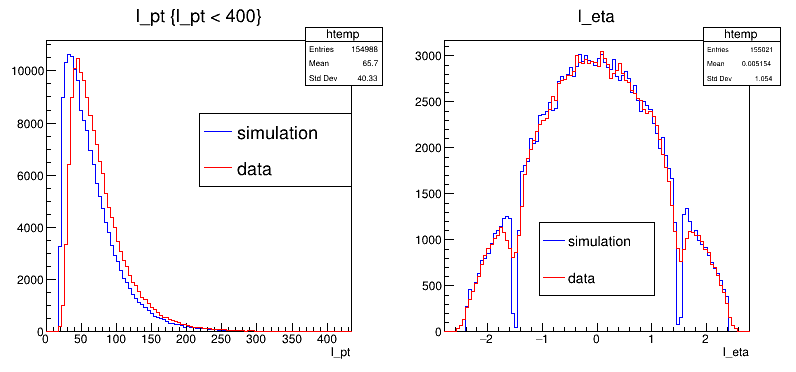

In [3]:
input_file = ROOT.TFile.Open("../../Datasets/TTbar/ee_ttbarsignalplustau_pseudo_data.root")

input_tree = input_file.Get("DecayTree")
#Create TCanvas and plot pt, and eta of the lepton
canvas_2 = TCanvas("canvas", "Comparing monte carlo and data", 800, 400)
canvas_2.Divide(2,1)

#Plot pt
canvas_2.cd(1)
input_tree.SetLineColor(ROOT.kBlue)
input_tree.Draw("l_pt", "l_pt < 400")
input_tree.SetLineColor(ROOT.kRed)
input_tree.Draw("l_pt_pseudodata", "1", "same")

#Create legend
legend = ROOT.TLegend(0.5,0.5,0.9,0.7)
legend.AddEntry("simulation", "simulation", "L").SetLineColor(ROOT.kBlue)
legend.AddEntry("data", "data", "L").SetLineColor(ROOT.kRed)
legend.Draw()

#Plot eta
canvas_2.cd(2)
input_tree.SetLineColor(ROOT.kBlue)
input_tree.Draw("l_eta")
input_tree.SetLineColor(ROOT.kRed)
input_tree.Draw("l_eta_pseudodata", "1", "same")

#Create Legend
legend_2 = ROOT.TLegend(0.35,0.2,0.65,0.4)
legend_2.AddEntry("simulation", "simulation", "L").SetLineColor(ROOT.kBlue)
legend_2.AddEntry("data", "data", "L").SetLineColor(ROOT.kRed)
legend_2.Draw()


canvas_2.Draw()

As we can see, the lepton $P_t$ and $eta$ are slightly different between the simulated and data distributions. We will want to correct for these minor difference now. Thankfully, `GBReweighter` works with panda's dataframes the same way `scikit-learn`'s package does.

In [4]:
from hep_ml.reweight import GBReweighter
from root_pandas import read_root, to_root

In [5]:
#Read simulation and data to separate frames
input_mc_frame = read_root("../../Datasets/TTbar/ee_ttbarsignalplustau_pseudo_data.root", columns = ["l_pt", "l_eta"], key = "DecayTree")
input_data_frame = read_root("../../Datasets/TTbar/ee_ttbarsignalplustau_pseudo_data.root", columns = ["l_pt_pseudodata", "l_eta_pseudodata"], key = "DecayTree")

In [6]:
#Create reweighter object
reweighter = GBReweighter(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 3,
    min_samples_leaf = 10)

#Fit reweighter to simulation and data
reweighter.fit(input_mc_frame, input_data_frame)

GBReweighter(gb_args={}, learning_rate=0.1, loss_regularization=5.0,
       max_depth=3, min_samples_leaf=10, n_estimators=100)

Once the reweighter is trained to find the differneces between simulation and data, it can then predict weights for the simulation.

In [7]:
mc_weights = reweighter.predict_weights(input_mc_frame)


#Add weights to output file
output_mc_frame = read_root("../../Datasets/TTbar/ee_ttbarsignalplustau_pseudo_data.root", key = "DecayTree")
output_mc_frame["sWeights"] = mc_weights
to_root(output_mc_frame, "../../Datasets/TTbar/ee_ttbarsignalplustau_pseudo_data_weighted.root", key = "DecayTree")

Now let's see what the reweighted data looks like.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


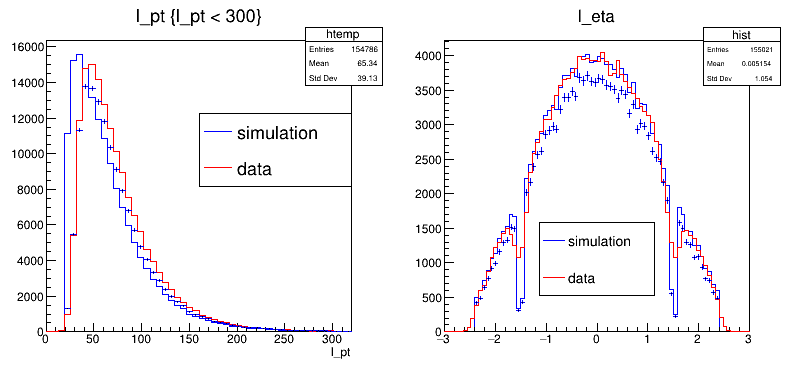

In [25]:
input_file_weighted = ROOT.TFile.Open("../../Datasets/TTbar/ee_ttbarsignalplustau_pseudo_data_weighted.root")

input_tree_weighted = input_file_weighted.Get("DecayTree")
#Create TCanvas and plot pt, and eta of the lepton
canvas_3 = TCanvas("canvas", "Comparing monte carlo and data", 800, 400)
canvas_3.Divide(2,1)

#Plot pt
canvas_3.cd(1)
input_tree_weighted.SetLineColor(ROOT.kBlue)
input_tree_weighted.Draw("l_pt", "l_pt < 300")
input_tree_weighted.SetLineColor(ROOT.kRed)
input_tree_weighted.Draw("l_pt_pseudodata", "1", "same")
input_tree_weighted.SetLineColor(ROOT.kBlue)
input_tree_weighted.Draw("l_pt", "1*sWeights", "same")

#Create legend
legend = ROOT.TLegend(0.5,0.5,0.9,0.7)
legend.AddEntry("simulation", "simulation", "L").SetLineColor(ROOT.kBlue)
legend.AddEntry("data", "data", "L").SetLineColor(ROOT.kRed)
legend.Draw()

#Plot eta
canvas_3.cd(2)
input_tree_weighted.SetLineColor(ROOT.kBlue)
input_tree_weighted.Draw("l_eta>>hist(80, -3, 3)", "1")
input_tree_weighted.SetLineColor(ROOT.kRed)
input_tree_weighted.Draw("l_eta_pseudodata", "1", "same")    
input_tree_weighted.SetLineColor(ROOT.kBlue)
input_tree_weighted.Draw("l_eta", "1*sWeights", "same")

#Create Legend
legend_2 = ROOT.TLegend(0.35,0.2,0.65,0.4)
legend_2.AddEntry("simulation", "simulation", "L").SetLineColor(ROOT.kBlue)
legend_2.AddEntry("data", "data", "L").SetLineColor(ROOT.kRed)
legend_2.Draw()


canvas_3.Draw()

As we can see, the reweighting has led to better agreement between simulation and data $P_t$. However, this is at the expense of more disagreement between simulation and data eta. Like classifiers, reweighting is not fool-proof method for correcting for all the differences between simulation and data. It is neccesarry to input relevant distributions and tune the hyperparameters to get the best results, so that it can be useful tool in analysis.